In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [ ]:
def LoadImage(name, path="/content/drive/MyDrive/cityscapes_data/train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

    
    return img/255, seg/255

In [ ]:
files =os.listdir("/content/drive/MyDrive/cityscapes_data/train")[0:10]

colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(n_clusters=13)

In [ ]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

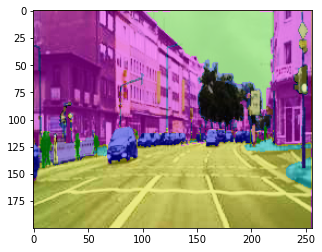

In [ ]:
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("5.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plot.imshow(total[:,:,:])
plot.show()

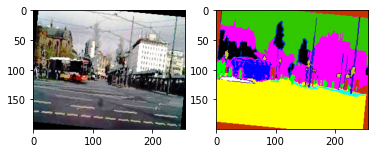

In [ ]:
def Generate(path="/content/drive/MyDrive/cityscapes_data/train", batch_size=10,
            maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[0])
plot.subplot(122)
plot.imshow(LayersToRGBImage(segs[0]))
plot.show()

In [ ]:
inp = Input(shape=(200, 256, 3))

x1 = BatchNormalization()(inp)
x1 = Conv2D(64, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)
#p1 = Dropout(0.2)(p1)

#x2 = BatchNormalization()(x1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)
#p2 = Dropout(0.2)(p2)

#x3 = BatchNormalization()(x2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)
#p3 = Dropout(0.2)(p3)

#x4 = BatchNormalization()(x3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)
#x4 = MaxPooling2D()(x4)
#x4 = Dropout(0.2)(x4)

x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
#x5 = Dropout(0.2)(x5)

x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 6, activation="relu", padding="same")(x6)
#x6 = Dropout(0.2)(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(13, 6, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 6, activation="softmax", padding="same")(x7)

model = Model(inp, x7)

opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
             loss="categorical_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 200, 256, 64  27712       ['batch_normalization[0][0]']    
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_gen = Generate()
val_gen = Generate("/content/drive/MyDrive/cityscapes_data/val")

In [ ]:
clb = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=1)]

h = model.fit(train_gen, epochs=1, steps_per_epoch=10,
                       validation_data=val_gen, validation_steps=10,
                       callbacks=clb, verbose=1)

 1/10 [==>...........................] - ETA: 28:39 - loss: 2.2170 - accuracy: 0.0572

In [ ]:
model.save("model.h5")
model = load_model("loss.h5")

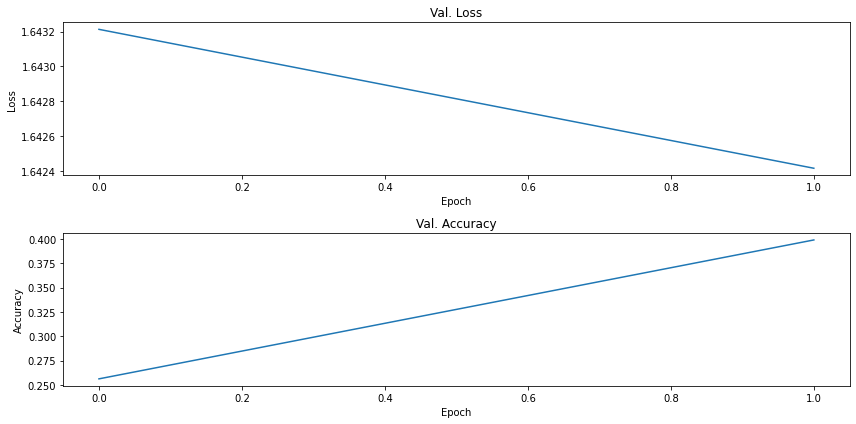

In [ ]:

loss = h.history["val_loss"]
acc = h.history["val_accuracy"]

plot.figure(figsize=(12, 6))
plot.subplot(211)
plot.title("Val. Loss")
plot.plot(loss)
plot.xlabel("Epoch")
plot.ylabel("Loss")

plot.subplot(212)
plot.title("Val. Accuracy")
plot.plot(acc)
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

plot.tight_layout()
plot.savefig("learn.png", dpi=150)
plot.show()

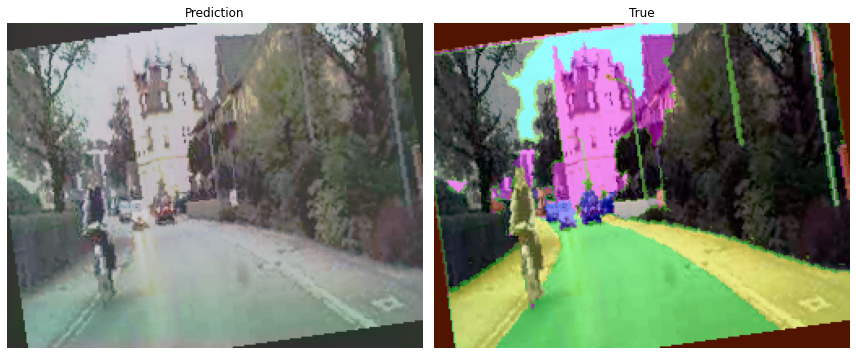

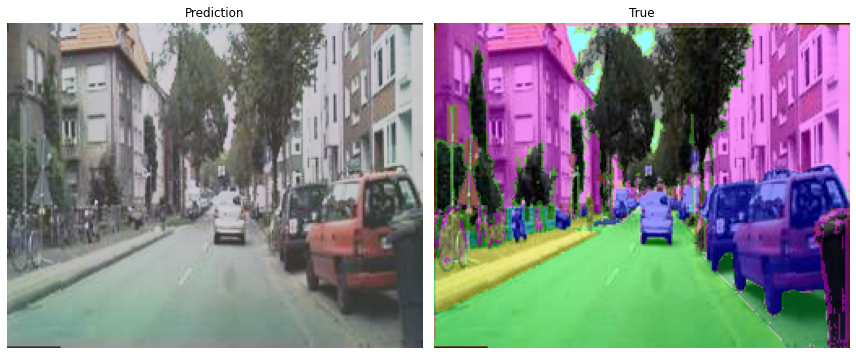

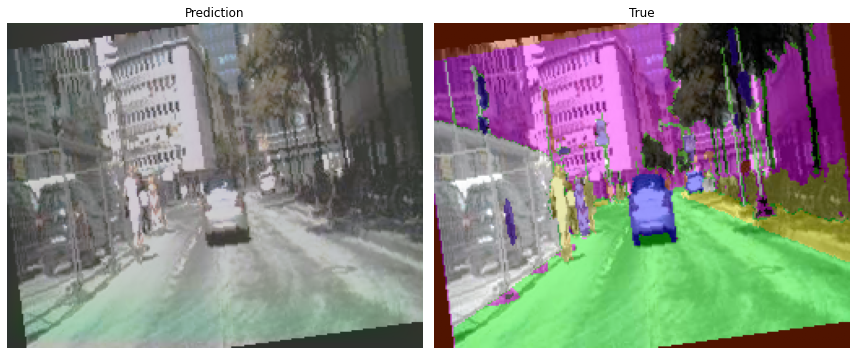

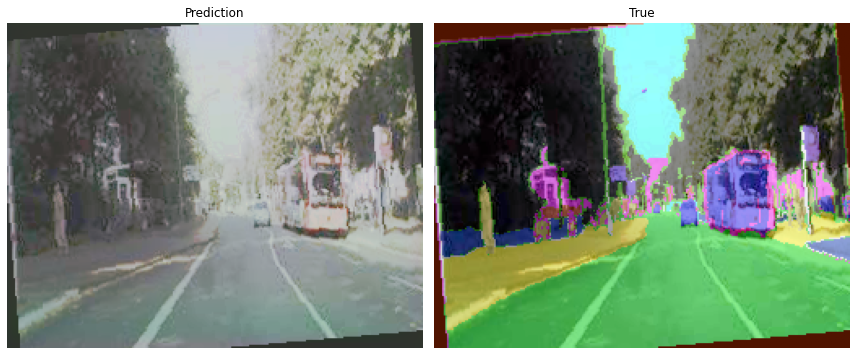

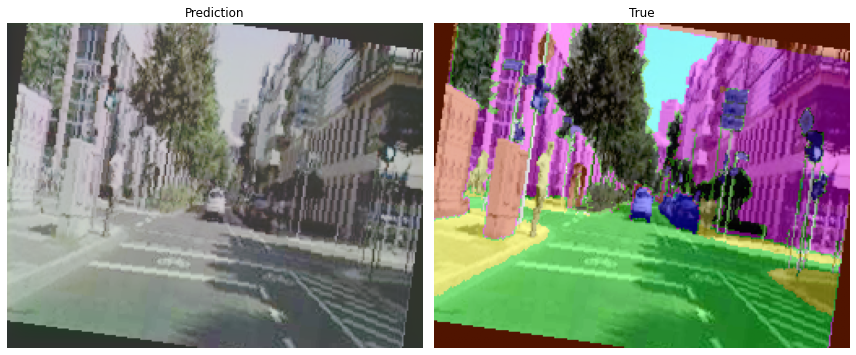

In [ ]:

test_gen = Generate("/content/drive/MyDrive/cityscapes_data/val")
max_show=4
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


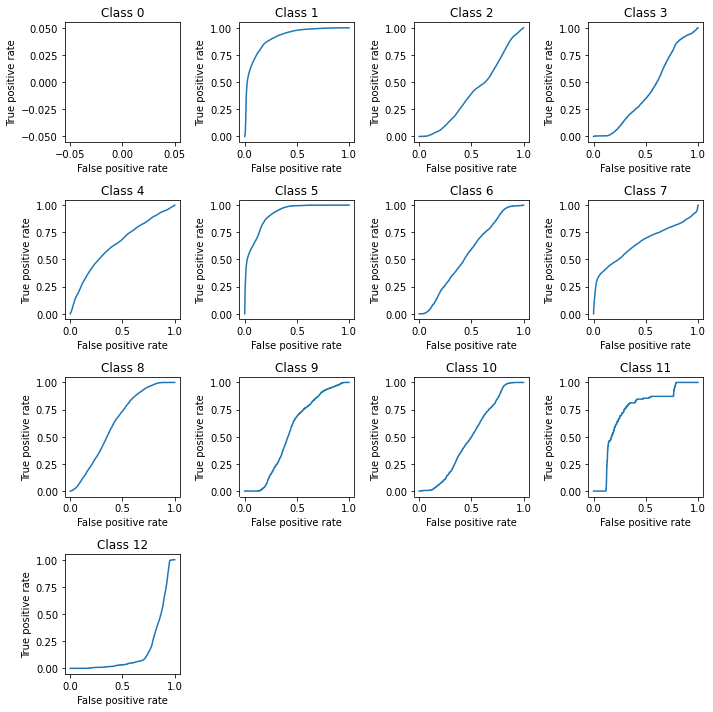

In [ ]:

from sklearn.metrics import roc_curve, balanced_accuracy_score
test_gen = Generate("/content/drive/MyDrive/cityscapes_data/val", batch_size=4)
max_show=4

bass = []

for imgs, segs in test_gen:
    p = model.predict(imgs)
    
    plot.figure(figsize=(10, 10))
    for i in range(p.shape[-1]):
        fpr, tpr, _ = roc_curve(segs[:,:,:,i].ravel(), p[:,:,:,i].ravel())
        
        _p = np.round(p[:,:,:,i].ravel()).astype(np.int32)
        bas = balanced_accuracy_score(segs[:,:,:,i].ravel(), _p)
        
        bass.append(bas)
        
        plot.subplot(4,4,i+1)
        plot.plot(fpr, tpr)
        plot.title("Class "+str(i))
        plot.xlabel("False positive rate")
        plot.ylabel("True positive rate")
    
    plot.tight_layout()
    plot.show()
    
    break

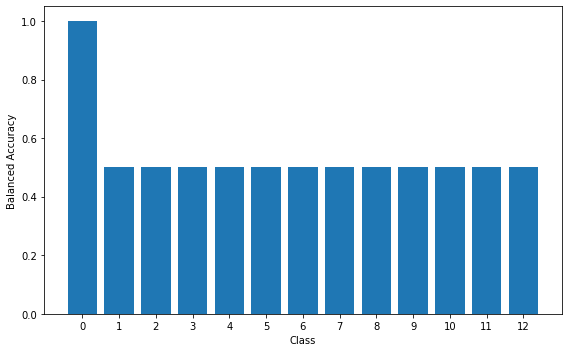

In [ ]:
plot.figure(figsize=(8, 5))
plot.bar(np.arange(0, len(bass)), bass)
plot.xticks(np.arange(0, len(bass)))
plot.ylabel("Balanced Accuracy")
plot.xlabel("Class")
plot.tight_layout()
plot.savefig("bas.png")
plot.show()